In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

from backtest import backtest_rebalance, backtest_dca

In [2]:
start = "2023-01-01"
end = "2026-01-01"

symbols = {
    "BTC": "BTC-USD",
    "ETH": "ETH-USD",
    "BNB": "BNB-USD",
    "XRP": "XRP-USD",
    "SOL": "SOL-USD",
    "TRON": "TRX-USD",
    "ADA": "ADA-USD",
    "XMR": "XMR-USD",
}

initial_capital = 1.0
target_weights = None
threshold = 0.05
fee = 0.001   

In [3]:
# df = pd.DataFrame()
# for k, v in symbols.items():
#     df[k] = yf.download(v, start=start, end=end)["Close"]

# df.to_csv("prices.csv")

In [4]:
df_origin = pd.read_csv("prices.csv", index_col=0, parse_dates=True)
df_origin

,BTC,ETH,BNB,XRP,SOL,TRON,ADA,XMR
Date,,,,,,,,
2023-01-01,16625.080078,1200.964844,244.136978,0.338763,9.982173,0.054820,0.249771,148.576935
2023-01-02,16688.470703,1214.656616,245.535904,0.348556,11.272967,0.055157,0.253828,147.943558
2023-01-03,16679.857422,1214.778809,246.133362,0.343824,13.344046,0.054833,0.252796,148.487930
2023-01-04,16863.238281,1256.526611,259.119690,0.347794,13.435113,0.054732,0.267677,150.743652
2023-01-05,16836.736328,1250.438599,256.422852,0.338039,13.419330,0.053661,0.269102,155.921738
...,...,...,...,...,...,...,...,...
2025-12-27,87802.156250,2947.998291,844.554504,1.872853,124.647713,0.284630,0.369542,453.496796
2025-12-28,87835.835938,2948.568115,858.828796,1.864360,125.199356,0.284914,0.368502,453.068542
2025-12-29,87138.140625,2934.538330,851.187561,1.847724,123.125229,0.284616,0.352915,437.445709


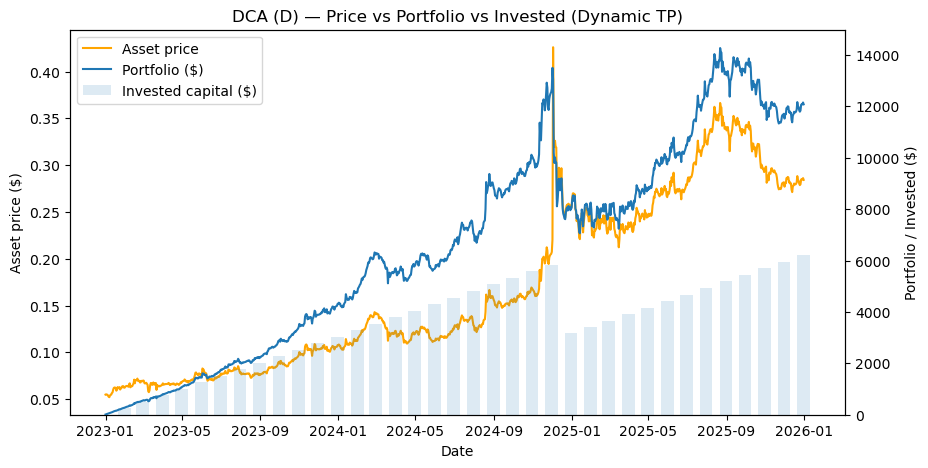

{'Total_invested': 9133.333333333283,
 'Final_value': 12076.81450144452,
 'Realized_profit': 10107.601956235518,
 'Num_rebalances': 1}

In [11]:
sol_prices = df_origin["TRON"]
invest_sum = 250 / 30

dca_result, dca_metrics = backtest_dca(
    prices=sol_prices,
    buy_amount=invest_sum,
    freq="D",
    available_sum=10000,
    profit_multiple=3,
    fee=0.001,
    plot=True
)

dca_metrics

In [30]:
results = {}

for symbol in symbols.keys():
    prices = df_origin[symbol]
    invest_sum = 50 / 30

    dca_result, dca_metrics = backtest_dca(
        prices=prices,
        buy_amount=invest_sum,
        freq="D",
        available_sum=10000,
        profit_multiple=3,
        fee=0.001,
        plot=False
    )

    results[symbol] = dca_metrics

In [31]:
res = pd.DataFrame(results).T

In [32]:
res['Total'] = res['Final_value'] + res['Realized_profit']
res['Profit'] = res['Total'] - res['Total_invested']
res.sort_values('Profit', ascending=False)

,Total_invested,Final_value,Realized_profit,Num_rebalances,Total,Profit
TRON,1826.666667,2415.362900,2021.520391,1.0,4436.883292,2610.216625
XMR,1826.666667,4363.739535,0.000000,0.0,4363.739535,2537.072869
XRP,1826.666667,1407.814515,2375.135220,2.0,3782.949735,1956.283068
BNB,1826.666667,1940.640366,1722.967348,1.0,3663.607713,1836.941047
BTC,1826.666667,3294.470028,0.000000,0.0,3294.470028,1467.803361
SOL,1826.666667,1110.224004,2044.871767,3.0,3155.095771,1328.429105
ETH,1826.666667,2272.463100,0.000000,0.0,2272.463100,445.796433
ADA,1826.666667,834.600326,1196.663666,1.0,2031.263992,204.597325


In [34]:
res['Profit'].sum(), res['Total_invested'].sum()

(12387.139832223955, 14613.33333333355)

In [ ]:
import numpy as np
import pandas as pd

def bootstrap_dca(df_origin, symbols, n_iterations=100, block_days=30, **backtest_kwargs):
    """
    Робить бутстрап для DCA, обираючи випадкові часові блоки.

    df_origin: DataFrame з цінами, індекс - дати, колонки - символи
    symbols: dict або список символів
    n_iterations: кількість повторень
    block_days: довжина випадкового відрізку
    backtest_kwargs: аргументи для backtest_dca
    """
    all_results = []

    dates = df_origin.index
    n_dates = len(dates)

    for i in range(n_iterations):
        # обираємо випадковий початок блоку
        start_idx = np.random.randint(0, n_dates - block_days)
        end_idx = start_idx + block_days
        block_dates = dates[start_idx:end_idx]

        df_block = df_origin.loc[block_dates]

        iteration_results = {}

        for symbol in symbols.keys():
            prices = df_block[symbol]

            dca_result, dca_metrics = backtest_dca(
                prices=prices,
                **backtest_kwargs
            )
            iteration_results[symbol] = dca_metrics

        all_results.append(iteration_results)

    # Перетворимо в DataFrame
    df_bootstrap = pd.DataFrame([
        {**res, 'iteration': i} for i, res_dict in enumerate(all_results)
        for symbol, res in res_dict.items()
    ])

    return df_bootstrap

In [47]:
bootstrap_df = bootstrap_dca(
    df_origin,
    symbols,
    n_iterations=100,          # скільки випадків створити
    block_days=365,            # довжина відрізку часу
    buy_amount=50/30,
    freq="D",
    available_sum=10000,
    profit_multiple=3,
    fee=0.001,
    plot=False
)

# Аналіз прибутку
bootstrap_df['Total'] = bootstrap_df['Final_value'] + bootstrap_df['Realized_profit']
bootstrap_df['Profit'] = bootstrap_df['Total'] - bootstrap_df['Total_invested']

# Середній прибуток по ітераціях
mean_profit = bootstrap_df.groupby('iteration')['Profit'].sum()
mean_invested = bootstrap_df.groupby('iteration')['Total_invested'].sum()
procent_returns = (mean_profit / mean_invested)


print(procent_returns.describe())

count    100.000000
mean       0.456510
std        0.233678
min       -0.054505
25%        0.295843
50%        0.461438
75%        0.596388
max        1.057459
dtype: float64
